0.14409722222222224 48
6.916666666666667 6.916666666666664
[5.70654073e-04 4.61153311e-03 1.82450210e-02 4.70990467e-02
 8.92063587e-02 1.32162930e-01 1.59462304e-01 1.61079569e-01
 1.38984223e-01 1.03995407e-01 6.82825824e-02 3.97129384e-02
 2.06150159e-02 9.61111989e-03 4.04524823e-03 1.54370392e-03
 5.36030051e-04 1.69871831e-04 4.92540254e-05 1.30930419e-05
 3.19624257e-06 7.17479739e-07 1.48245629e-07 2.82136051e-08
 4.94787276e-09 7.99688645e-10 1.19098582e-10 1.63379168e-11
 2.06295197e-12 2.39525793e-13 2.55397009e-14 2.49665073e-15
 2.23299581e-16 1.82274167e-17 1.35384404e-18 9.11716475e-20
 5.54283343e-21 3.02651285e-22 1.47496863e-23 6.36721259e-25
 2.41192079e-26 7.92319500e-28 2.22320888e-29 5.22268984e-31
 9.99177708e-33 1.49527608e-34 1.64178386e-36 1.17619491e-38
 4.12543007e-41]


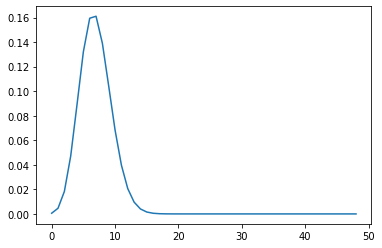

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats

test_rate = 498000 / 72000
spawn_attempts = 48
success_rate = test_rate / spawn_attempts

test_spawn_range = np.arange(0, spawn_attempts + 1)
test_spawn_pmf = scipy.stats.binom.pmf(test_spawn_range, 48, success_rate)
print(success_rate, spawn_attempts)
test_average = np.sum(test_spawn_range * test_spawn_pmf)
print(test_rate, test_average)
print(test_spawn_pmf)

plt.plot(test_spawn_range, test_spawn_pmf)
plt.show()

In [2]:
def compute_spawn_dependent_drop_pmf(spawn_pmf_range, spawn_pmf, drop_min, drop_max):
    n = spawn_pmf_range[-1]
    final_size = (n * (drop_max - drop_min) + 1)
    outcomes_per_roll = drop_max - drop_min + 1
    single_roll_chance = 1 / outcomes_per_roll

    du_sum_pmf = np.zeros(final_size)
    du_sum_pmf[0] = 1

    temp_du_sum_pmf = np.zeros(final_size)

    combined_pmf_offset = drop_min
    combined_pmf = np.zeros(n*drop_max - drop_min + 1)
    if spawn_pmf_range[0] == 0:
        combined_pmf[0] = spawn_pmf[0]

    for i in range(1, n+1):
        prior_range = (i-1) * (drop_max - drop_min) + 1
        new_range = i * (drop_max - drop_min)+1

        for dice in range(drop_min, outcomes_per_roll + drop_min):
            temp_du_sum_pmf[dice - drop_min: dice - drop_min + prior_range] += du_sum_pmf[:prior_range] * single_roll_chance
        
        if drop_min * i >= combined_pmf_offset:
            combined_pmf_index = drop_min * i - combined_pmf_offset
            combined_pmf[combined_pmf_index:combined_pmf_index + new_range] += temp_du_sum_pmf[:new_range] * spawn_pmf[i]

        (du_sum_pmf, temp_du_sum_pmf) = (temp_du_sum_pmf, du_sum_pmf)
        temp_du_sum_pmf[:new_range] = 0
    all_combined_counts = np.arange(drop_min, len(combined_pmf) + drop_min)
    return (all_combined_counts, combined_pmf)

drop_chance_per_tick_range, drop_chance_per_tick = compute_spawn_dependent_drop_pmf(test_spawn_range, test_spawn_pmf, 0, 4)
average_per_tick = np.sum(drop_chance_per_tick_range*drop_chance_per_tick)
print(test_rate*2, average_per_tick, np.sum(drop_chance_per_tick))



13.833333333333334 13.833333333333336 1.0000000000000002


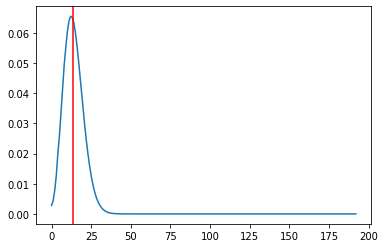

In [3]:
plt.plot(drop_chance_per_tick_range, drop_chance_per_tick)
plt.axvline(x=test_rate*2, color='red')
plt.show()

In [4]:
from util_functions import discrete_pmf_sum_pmf

interval =16
repeats = 2
scaled_drop_rate_range, scaled_drop_rate_pmf = discrete_pmf_sum_pmf(drop_chance_per_tick_range, drop_chance_per_tick, interval*repeats)
print(test_rate*2*interval*repeats)
print(np.sum(scaled_drop_rate_range * scaled_drop_rate_pmf))

553.3333333333334
553.3333333333363


0.025086396275876183
0.39982202193236316
719.6796394782536
0.01515686642587337


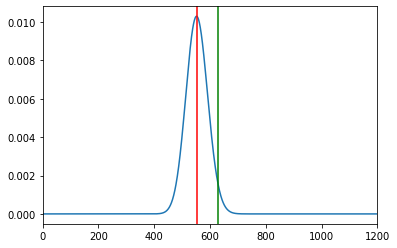

In [5]:
def compute_loss(drop_range, drop_chance, limit, period):
    if limit >= drop_range[0] and limit < drop_range[-1] and len(drop_range) > 1:
        loss_index = limit - drop_range[0] + 1
        chance_loss = np.sum(drop_chance[loss_index:])
        expected_loss = np.sum(drop_chance[loss_index:] * (drop_range[loss_index:] - limit))
    elif limit < drop_range[0]:
        chance_loss = 1.0
        expected_loss = np.sum(drop_chance * (drop_range - limit))
    elif limit >= drop_range[-1]:
        chance_loss = 0.0
        expected_loss = 0.0

    periods_per_hr = 72000 / period
    expected_loss_per_hr = expected_loss * periods_per_hr
    expected_hours_before_loss = np.log(0.5) / np.log(1 - chance_loss) / periods_per_hr

    print(chance_loss)
    print(expected_loss)
    print(expected_loss_per_hr)
    print(expected_hours_before_loss)

test_limit_per_interval = 315
test_limit = test_limit_per_interval * repeats
compute_loss(scaled_drop_rate_range, scaled_drop_rate_pmf, test_limit, interval * repeats)


plt.xlim(0, 600*repeats)
plt.plot(scaled_drop_rate_range, scaled_drop_rate_pmf)
plt.axvline(x=test_rate*2*interval*repeats, color='red')
plt.axvline(x=test_limit, color='green')
plt.show()